In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
import warnings
from tqdm import tqdm

from flash_ansr import FlashANSR, get_path, FlashANSRTransformer, ExpressionSpace
from flash_ansr.refine import ConvergenceError
from flash_ansr.expressions.utils import codify, num_to_constants

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'cpu'
print(f"Using device: {device}")

Using device: cuda


In [2]:
MODEL = 'v6.0'
READ = True

In [3]:
RES = 49
mu_list = np.linspace(-5, 5, RES)
sigma_low = -1
sigma_high = (RES - 1) / 19 - 1
sigma_list = np.logspace(sigma_low, sigma_high, RES)  # 10**0 at entry 19
N_REPEAT = 5

In [4]:
assert 0 in mu_list
assert 1 in sigma_list

In [5]:
nsr = FlashANSR(
    expression_space=ExpressionSpace.from_config(get_path('models', 'ansr-models', MODEL, 'expression_space.yaml')),
    flash_ansr_transformer=FlashANSRTransformer.load(get_path('models', 'ansr-models', MODEL))[1].to(device).eval(),
    beam_width=32,
    n_restarts=8,
    equivalence_pruning=True,
    p0_noise='uniform',
    p0_noise_kwargs={'low': -5, 'high': 5},  # Training prior
)

nsr.flash_ansr_transformer.to(device).eval()


print(f'{nsr.flash_ansr_transformer.n_params:,} parameters')

27,137,058 parameters


In [6]:
if not READ:
    results = np.zeros((len(mu_list), len(sigma_list), N_REPEAT))
    pbar = tqdm(total=results.size)

    with torch.no_grad():
        for i, mu in enumerate(mu_list):
            for j, sigma in enumerate(sigma_list):
                for k in range(N_REPEAT):
                    demo_expressions = [
                        ('exp(- (x - 1)**2 / 1)', (mu, sigma), (-10, 10)),
                    ]

                    expression, constants, xlim = demo_expressions[0]

                    prefix_expression = nsr.expression_space.parse_expression(expression, mask_numbers=True)
                    prefix_expression_w_num = nsr.expression_space.operators_to_realizations(prefix_expression)
                    prefix_expression_w_constants, constants_names = num_to_constants(prefix_expression_w_num)
                    code_string = nsr.expression_space.prefix_to_infix(prefix_expression_w_constants, realization=True)
                    code = codify(code_string, nsr.expression_space.variables + constants_names)

                    if constants is None:
                        demo_function = lambda x: nsr.expression_space.code_to_lambda(code)(x, 0, 0)
                    else:
                        demo_function = lambda x: nsr.expression_space.code_to_lambda(code)(x, 0, 0, *constants)

                    x = np.random.uniform(*xlim, 500)

                    y = demo_function(x)

                    x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(-1).to(device)
                    y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(-1).to(device)

                    pad_length = nsr.flash_ansr_transformer.encoder_max_n_variables - x_tensor.shape[1] - y_tensor.shape[1]
                    x_tensor = nn.functional.pad(x_tensor, (0, pad_length, 0, 0), value=0)

                    try:
                        nsr.fit(x_tensor, y_tensor, converge_error='raise')
                    except ConvergenceError:
                        results[i, j, k] = np.nan
                        pbar.update(1)
                        pbar.set_postfix(fvu=np.nan, mu=mu, sigma=sigma, i=i, j=j, k=k)
                        continue

                    warnings.filterwarnings("ignore", category=RuntimeWarning)
                    try:
                        y_pred = nsr.predict(x_tensor.cpu().numpy())
                    except (RuntimeError, OverflowError):
                        results[i, j, k] = np.nan
                        pbar.update(1)
                        pbar.set_postfix(fvu=np.nan, mu=mu, sigma=sigma, i=i, j=j, k=k)
                        continue
                    
                    fvu = np.mean((y_pred[:, 0] - demo_function(x))**2) / np.var(demo_function(x))

                    results[i, j, k] = fvu

                    pbar.update(1)
                    pbar.set_postfix(fvu=fvu, mu=mu, sigma=sigma, i=i, j=j, k=k)
    np.save(get_path('results', 'constants_variation', 'gaussians', create=True, filename=f'{MODEL}_res-{RES}_rep-{N_REPEAT}.npy'), results)
else:
    results = np.load(get_path('results', 'constants_variation', 'gaussians', filename=f'{MODEL}_res-{RES}_rep-{N_REPEAT}.npy'))

In [7]:
results_median = np.nanmedian(results, axis=-1)

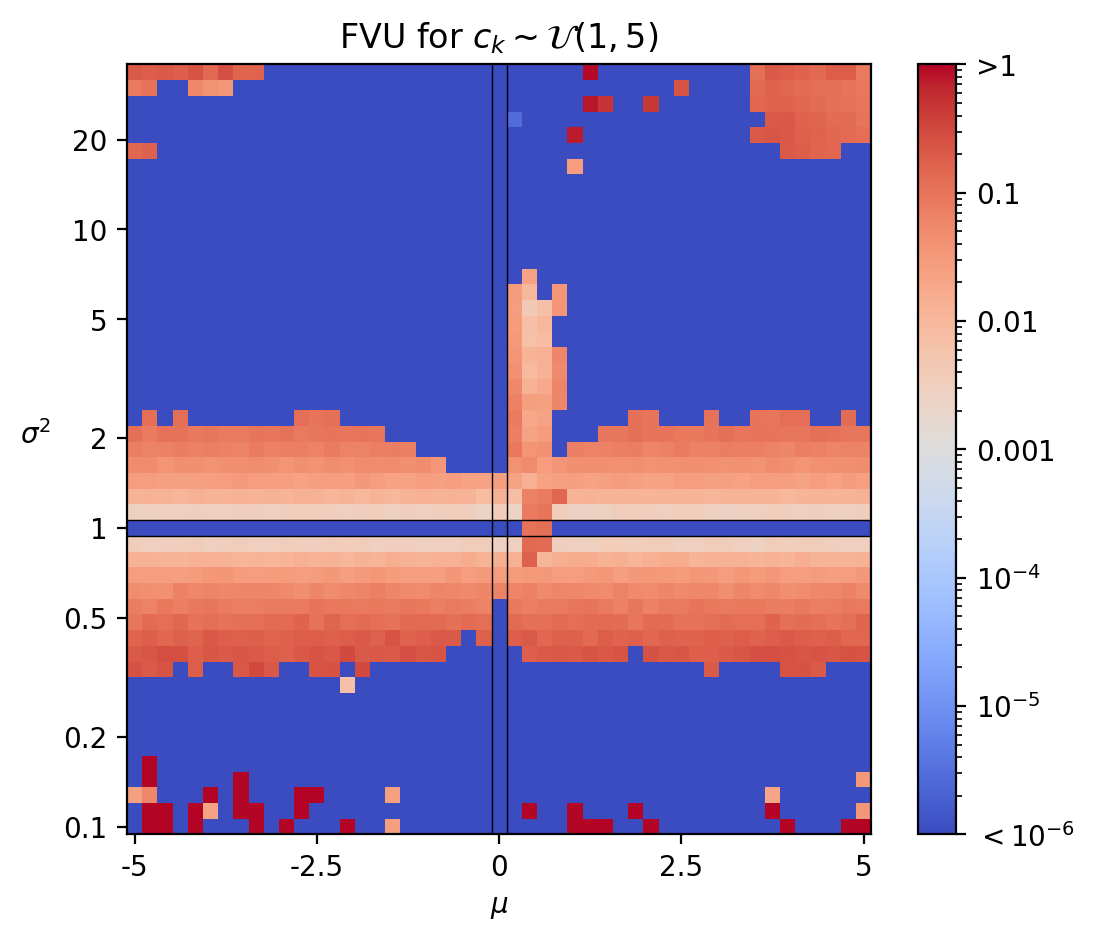

In [8]:
fig, ax = plt.subplots(figsize=(6, 5), dpi=200)
# cax = ax.pcolormesh(mu_list, sigma_list, results_median.T, cmap='coolwarm', vmin=0, vmax=1)
cax = ax.pcolormesh(np.arange(len(mu_list)), np.arange(len(sigma_list)), results_median.T, cmap='coolwarm', norm=LogNorm(vmin=1e-6, vmax=1), rasterized=True)
colorbar = fig.colorbar(cax)

# Where the result is nan, draw a black square with a white cross
for i, mu in enumerate(mu_list):
    for j, sigma in enumerate(sigma_list):
        if np.isnan(results_median[i, j]):
            # Black square
            ax.add_patch(plt.Rectangle((mu - 0.5 / RES * 10, sigma - 0.5 / RES * 25), 1 / RES * 10, 1 / RES * 25, color='black'))
            # White cross
            ax.plot([mu - 0.5 / RES * 10, mu + 0.5 / RES * 10], [sigma - 0.5 / RES * 25, sigma + 0.5 / RES * 25], color='white', linewidth=0.5)
            ax.plot([mu - 0.5 / RES * 10, mu + 0.5 / RES * 10], [sigma + 0.5 / RES * 25, sigma - 0.5 / RES * 25], color='white', linewidth=0.5)

# Set xticks for the colorbar
colorbar.set_ticks([1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1])
colorbar.set_ticklabels(['$<10^{-6}$', '$10^{-5}$', '$10^{-4}$', '$0.001$', '$0.01$', '$0.1$', '>1'])

steps = 11
ytick_values = np.array([0.1, 0.2, 0.5, 1, 2, 5, 10, 20])
yticks = np.log10(ytick_values)
ax.set_yticks((yticks - sigma_low) / (sigma_high - sigma_low) * (RES - 1))
ax.set_yticklabels(int(x) if x == int(x) else f'{x:.1f}' for x in ytick_values)

xtick_values = np.array([-5, -2.5, 0, 2.5, 5])
xticks = (xtick_values - mu_list[0]) / (mu_list[-1] - mu_list[0]) * (RES - 1)
ax.set_xticks(xticks)
ax.set_xticklabels(int(x) if x == int(x) else f'{x:.1f}' for x in xtick_values)

ax.axhline(18.5, color='k', linewidth=0.5)
ax.axhline(19.5, color='k', linewidth=0.5)
ax.axvline(23.5, color='k', linewidth=0.5)
ax.axvline(24.5, color='k', linewidth=0.5)

# ax.set_title('FVU for $c_k \sim \mathcal{U}(-5, 5)$')
ax.set_title('FVU for $c_k \sim \mathcal{U}(1, 5)$')
ax.set_xlabel('$\mu$')
ax.set_ylabel('$\sigma^2$', rotation=0, labelpad=10);

In [9]:
def get_model_for_special(m, s, x, x_linspace) -> tuple[FlashANSR, float, np.ndarray, np.ndarray, np.ndarray, str]:
    demo_expressions = [
        ('exp(- (x - 1)**2 / 1)', (m, s), (-10, 10)),
    ]

    expression, constants, xlim = demo_expressions[0]

    prefix_expression = nsr.expression_space.parse_expression(expression, mask_numbers=True)
    prefix_expression_w_num = nsr.expression_space.operators_to_realizations(prefix_expression)
    prefix_expression_w_constants, constants_names = num_to_constants(prefix_expression_w_num)
    code_string = nsr.expression_space.prefix_to_infix(prefix_expression_w_constants, realization=True)
    code = codify(code_string, nsr.expression_space.variables + constants_names)

    if constants is None:
        demo_function = lambda x: nsr.expression_space.code_to_lambda(code)(x, 0, 0)
    else:
        demo_function = lambda x: nsr.expression_space.code_to_lambda(code)(x, 0, 0, *constants)

    y = demo_function(x)

    nsr.fit(x[:, None], y, converge_error='raise')

    y_pred_linspace = nsr.predict(x_linspace.cpu().numpy())

    x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(-1).to(device)
    y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(-1).to(device)

    nsr.fit(x_tensor, y_tensor, converge_error='raise')

    y_pred = nsr.predict(x_tensor.cpu().numpy())
    
    return nsr, np.mean((nsr.predict(x_tensor.cpu().numpy())[:, 0] - y)**2) / np.var(y), y, y_pred, y_pred_linspace, nsr.get_expression()

In [10]:
xlim = (-10, 10)
x = np.random.uniform(*xlim, 500)
x_linspace_tensor = torch.linspace(-10.5, 10.5, 500).unsqueeze(-1).to(device)

In [11]:
# nsr, fvu, y, y_pred, y_pred_linspace, expression = get_model_for_special(0, 1, x, x_linspace_tensor)
# print(f'FVU: {fvu:.2e}')

In [12]:
special_indices = [
    (5, 35),
    (27, 30),
    (45, 45),
    (10, 12),
    (26, 19),
    (37, 22),
    (1, 1),
    (24, 3),
    (48, 3)
]

special_mu_list = [mu_list[i] for i, _ in special_indices]
special_sigma_list = [sigma_list[j] for _, j in special_indices]

results = [get_model_for_special(mu_list[mu_id], sigma_list[sigma_id], x, x_linspace_tensor) for mu_id, sigma_id in tqdm(special_indices)]

100%|██████████| 9/9 [01:25<00:00,  9.47s/it]


100%|██████████| 9/9 [00:00<00:00, 176.44it/s]
/tmp/ipykernel_5867/131260353.py:101: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


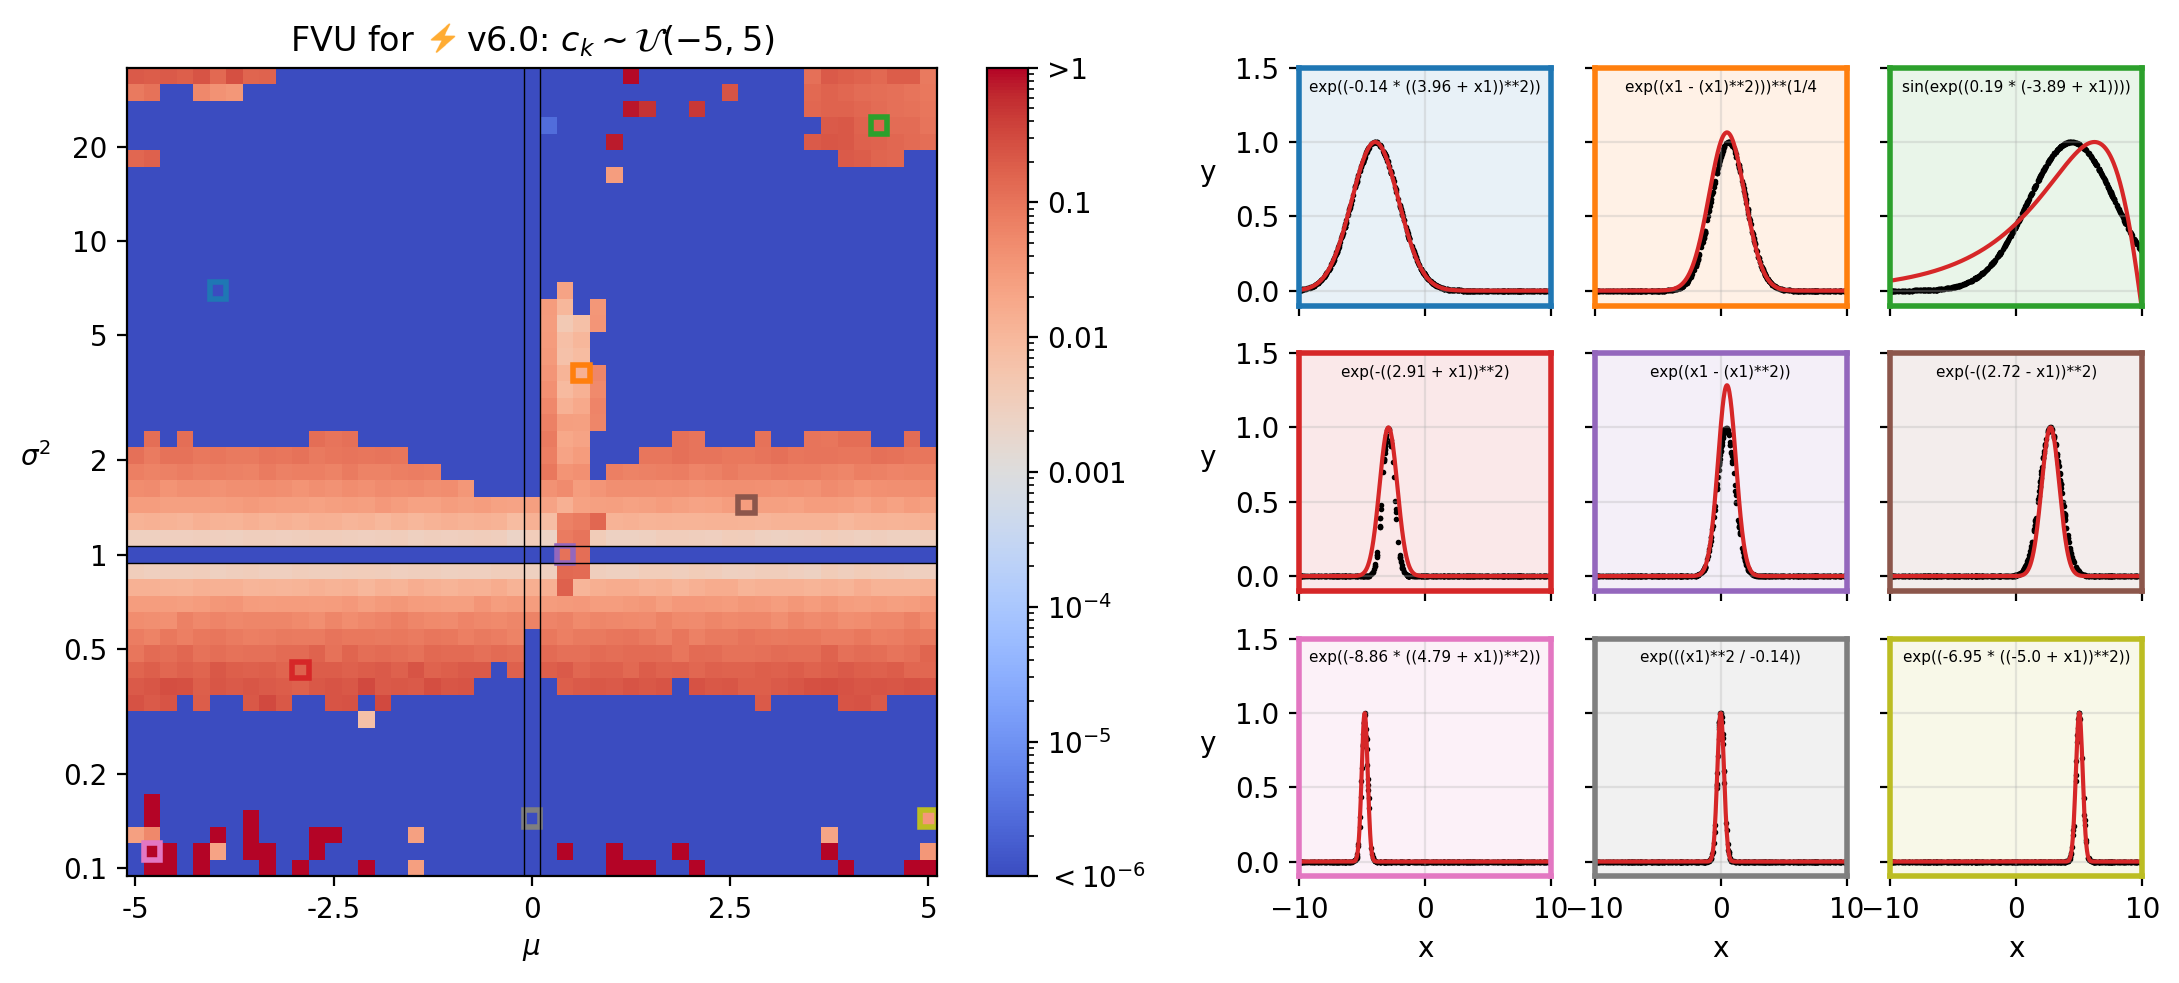

In [15]:
fig = plt.figure(figsize=(11, 5), dpi=200)

# Create two main columns of equal width using GridSpec
gs = gridspec.GridSpec(1, 2, width_ratios=[1.2, 1])

ax = fig.add_subplot(gs[0, 0])
ax.set_title('Large Left Plot')

# cax = ax.pcolormesh(mu_list, sigma_list, results_median.T, cmap='coolwarm', vmin=0, vmax=1)
cax = ax.pcolormesh(np.arange(len(mu_list)), np.arange(len(sigma_list)), results_median.T, cmap='coolwarm', norm=LogNorm(vmin=1e-6, vmax=1), rasterized=True)
colorbar = fig.colorbar(cax)


# Where the result is nan, draw a black square with a white cross
for i, mu in enumerate(mu_list):
    for j, sigma in enumerate(sigma_list):
        if np.isnan(results_median[i, j]):
            # Black square
            ax.add_patch(plt.Rectangle((mu - 0.5 / RES * 10, sigma - 0.5 / RES * 25), 1 / RES * 10, 1 / RES * 25, color='black'))
            # White cross
            ax.plot([mu - 0.5 / RES * 10, mu + 0.5 / RES * 10], [sigma - 0.5 / RES * 25, sigma + 0.5 / RES * 25], color='white', linewidth=0.5)
            ax.plot([mu - 0.5 / RES * 10, mu + 0.5 / RES * 10], [sigma + 0.5 / RES * 25, sigma - 0.5 / RES * 25], color='white', linewidth=0.5)

# Set xticks for the colorbar
colorbar.set_ticks([1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1])
colorbar.set_ticklabels(['$<10^{-6}$', '$10^{-5}$', '$10^{-4}$', '$0.001$', '$0.01$', '$0.1$', '>1'])

steps = 11
ytick_values = np.array([0.1, 0.2, 0.5, 1, 2, 5, 10, 20])
yticks = np.log10(ytick_values)
ax.set_yticks((yticks - sigma_low) / (sigma_high - sigma_low) * (RES - 1))
ax.set_yticklabels(int(x) if x == int(x) else f'{x:.1f}' for x in ytick_values)

xtick_values = np.array([-5, -2.5, 0, 2.5, 5])
xticks = (xtick_values - mu_list[0]) / (mu_list[-1] - mu_list[0]) * (RES - 1)
ax.set_xticks(xticks)
ax.set_xticklabels(int(x) if x == int(x) else f'{x:.1f}' for x in xtick_values)

ax.axhline(18.5, color='k', linewidth=0.5)
ax.axhline(19.5, color='k', linewidth=0.5)
ax.axvline(23.5, color='k', linewidth=0.5)
ax.axvline(24.5, color='k', linewidth=0.5)

ax.set_title('FVU for     v6.0: $c_k \sim \mathcal{U}(-5, 5)$')
# ax.set_title('FVU for     v6.4: $c_k \sim \mathcal{U}(1, 5)$')
ax.set_xlabel('$\mu$')
ax.set_ylabel('$\sigma^2$', rotation=0, labelpad=10);

gs_right = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=gs[0, 1])

for i, idxs in enumerate(special_indices):
    # Draw a square around the special point, no filling, outlined with C{i}
    ax.add_patch(plt.Rectangle((idxs[0] - 0.5, idxs[1] - 0.5), 1, 1, color=f'C{i}', fill=False, linewidth=2))

# Show the flash.png image next to the ANSR header
flash = plt.imread(get_path('assets', 'flash.png'))

# Create a new image with the flash.png image
# Apparently there is no feasable way to write emojis in matplotlib WTF?!
ax_image = fig.add_axes([0.177, 0.938, 0.035, 0.035], anchor='NE', zorder=10)
# ax_image = fig.add_axes([0.185, 0.938, 0.035, 0.035], anchor='NE', zorder=10)
ax_image.imshow(flash)
ax_image.axis('off')

n = 3

for i, (mu_id, sigma_id) in enumerate(tqdm(special_indices)):
    ax = fig.add_subplot(gs_right[i // n, i % n])

    nsr, fvu, y, y_pred, y_pred_linspace, expression = results[i]

    ax.scatter(x, y, label='Data', color='k', s=1)
    ax.plot(x_linspace_tensor.cpu().numpy(), y_pred_linspace[:, 0], label='Prediction', color='tab:red')
    if expression.startswith('(') and expression.endswith(')'):
        expression = expression[1:-1]
    ax.annotate(expression, xy=(0.5, 0.95), xycoords='axes fraction', ha='center', va='top', fontsize=5.5)#, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'))

    if i % n == 0:
        ax.set_ylabel('y', rotation=0, labelpad=10)
    else:
        ax.set_yticklabels([])

    if i // n == 2:
        ax.set_xlabel('x')
    else:
        ax.set_xticklabels([])

    ax.set_xlim(-10, 10)
    ax.set_ylim(-0.1, 1.5)

    ax.grid(alpha=0.3)

    # Make the outline the same color as the square
    for spine in ax.spines.values():
        spine.set_edgecolor(f'C{i}')
        spine.set_linewidth(2)
        
    # Make the facecolor also C{i} abut with less alpha
    ax.set_facecolor((*plt.cm.tab10(i)[:3], 0.1))

fig.tight_layout()

plt.savefig(get_path('results', 'constants_variation', 'gaussians', filename=f'{MODEL}_res-{RES}_rep-{N_REPEAT}_composite.svg'))